# Coarse Cleaned EP Patents

> Dataset available on HuggingFace https://huggingface.co/datasets/mhurhangee/ep-patents-coarse-cleaned
 
This dataset contains the description and first claim from granted **European Patent (EP) documents** that have been cleaned for NLP tasks such as pretraining language models. 

Contains one years worth of English granted EP patents from 04 September 2024 to 04 Sep 2025.

Each line is a JSON object representing a single patent with the following fields:

- `description`: The cleaned English description text.
- `claim1`: The cleaned first claim in English.

## Cleaning and Processing Steps

1. **Language Filtering**  
   - Only patents with an English description (`<description lang="en">`) are included.  
   - Only the first claim (`<claims lang="en"><claim num="0001">`) is extracted.

2. **Text Extraction**  
   - Text is extracted recursively from child XML elements.  
   - Paragraphs (`<p>`) are preserved and separated by double newlines (`\n\n`).

3. **Special Token Replacement**  
   Certain XML tags are replaced with tokens, with the original content removed:
   - `<table>` → `<TAB>`  
   - `<img>` → `<IMG>`  
   - `<figref>` → `<FIG>`  
   - `<patcit>` → `<CIT>`  
   - `<nplcit>` → `<NPL>`  
   - `<chemistry>` → `<CHM>`  
   - `<maths>` → `<MAT>`  
   - `<heading>` → `<HEAD>`  
   - `<ol>`, `<ul>`, `<dl>` → removed entirely

4. **Number Normalization**  
   - Numbers with optional SI units (e.g., "20 mm", "3.5 kg") are replaced with `<NUM>`.  
   - Numbers inside words like "CO2" are preserved.

5. **Whitespace Normalization**  
   - Redundant spaces are removed.  
   - Paragraph separation is maintained using double newlines.

6. **Comments Removal**  
   - XML comments such as `<!-- EPO <DP n="1"> -->` are removed.

7. **Output Format**  
   - Saved as **JSONL**, one patent per line.  
   - Suitable for downstream NLP processing, including language model pretraining.

## Github
Cleaning script and notebook example available at [https://github.com/mhurhangee/openpatent](https://github.com/mhurhangee/openpatent)

# Everything (quasi for a PDF not cleaned at all)

Processed 2417 XML patents
Average characters (description + claims): 78943
Median characters: 64311
Max characters: 696814


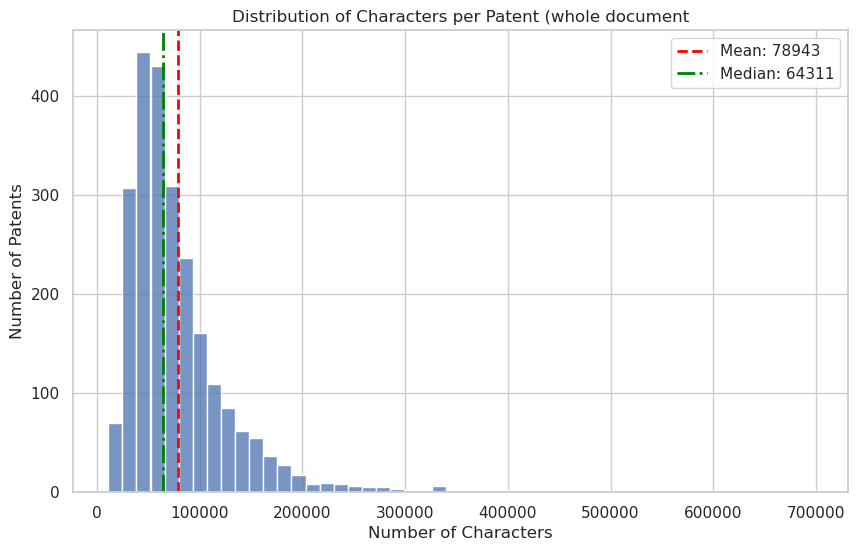

In [5]:
from lxml import etree
import os

folder = "./xml/20250101"

char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()
            
            # Find the <ep-patent-document> root explicitly
            ep_doc = root.find(".//ep-patent-document")
            if ep_doc is None:
                # Sometimes it's the root already
                if root.tag == "ep-patent-document":
                    ep_doc = root

            if ep_doc is not None:
                # Collect all text inside it
                full_text = "".join(ep_doc.itertext())
                full_text = " ".join(full_text.split())  # normalize whitespace
                if full_text:
                    char_counts.append(len(full_text))
                    num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

if char_counts:
    avg_chars = sum(char_counts) / len(char_counts)
    median_chars = sorted(char_counts)[len(char_counts)//2]
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents")
    print(f"Average characters (description + claims): {avg_chars:.0f}")
    print(f"Median characters: {median_chars}")
    print(f"Max characters: {max_chars}")
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Add mean and median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars}")

    plt.title("Distribution of Characters per Patent (whole document")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid text found in any XML files")


# Only description and claims

Processed 2417 XML patents
Average characters (description + claims): 76653
Median characters: 62219
Max characters: 692507


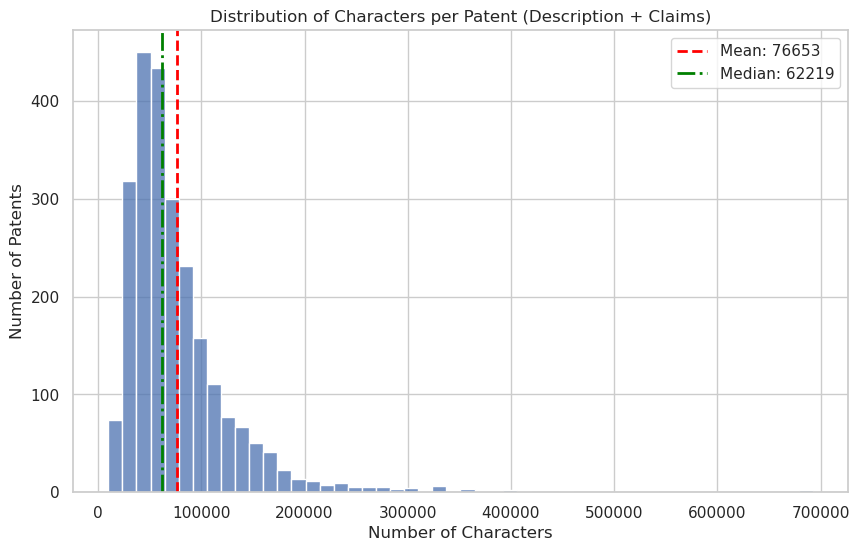

In [6]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt

folder = "./xml/20250101"

char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # Collect all text from description + claims
            texts = []
            for tag in ["description", "claims"]:
                for elem in root.findall(f".//{tag}"):
                    full_text = "".join(elem.itertext())
                    if full_text.strip():
                        texts.append(full_text)

            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())  # normalize whitespace
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Statistics + Histogram
# ------------------------
if char_counts:
    avg_chars = sum(char_counts) / len(char_counts)
    median_chars = sorted(char_counts)[len(char_counts)//2]
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents")
    print(f"Average characters (description + claims): {avg_chars:.0f}")
    print(f"Median characters: {median_chars}")
    print(f"Max characters: {max_chars}")

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Add mean and median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars}")

    plt.title("Distribution of Characters per Patent (Description + Claims)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid text found in any XML files")


Median drop by ~2k

# Only English description, and then only English claims

Processed 1977 XML patents (English only)
Average characters (description + claims): 68812
Median characters: 54067
Max characters: 671600


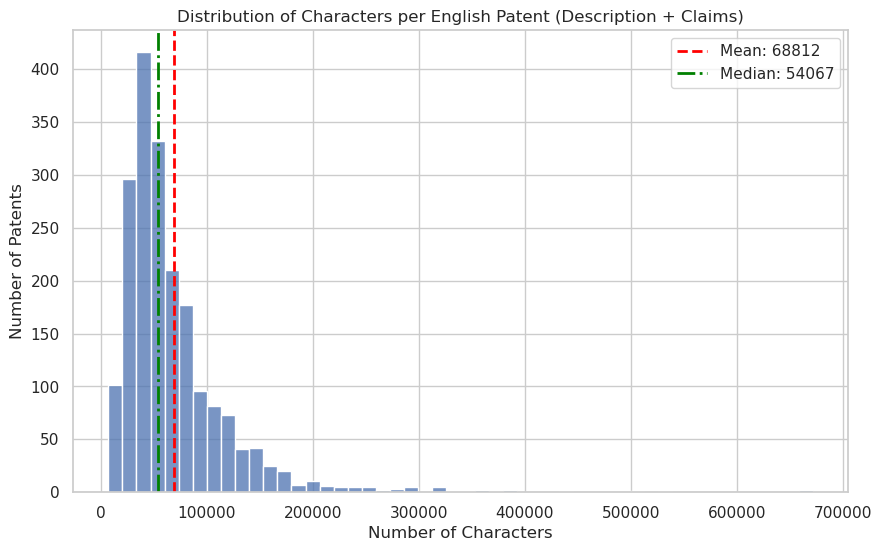

In [7]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

folder = "./xml/20250101"

char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # ----------------------
            # 1. Ensure description is in English
            # ----------------------
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue  # skip this patent entirely

            texts = []

            # Description text (English only, already filtered)
            desc_text = "".join(desc.itertext())
            if desc_text.strip():
                texts.append(desc_text)

            # ----------------------
            # 2. Claims in English
            # ----------------------
            for claims in root.findall(".//claims[@lang='en']"):
                claim_text = "".join(claims.itertext())
                if claim_text.strip():
                    texts.append(claim_text)

            # Combine & count characters
            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())  # normalize whitespace
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Statistics + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (English only)")
    print(f"Average characters (description + claims): {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters per English Patent (Description + Claims)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML files")

# Only keep independent claim w/ description

Processed 1977 XML patents (English only, first claim only)
Average characters (description + claim 1): 64680
Median characters: 49777
Max characters: 663964


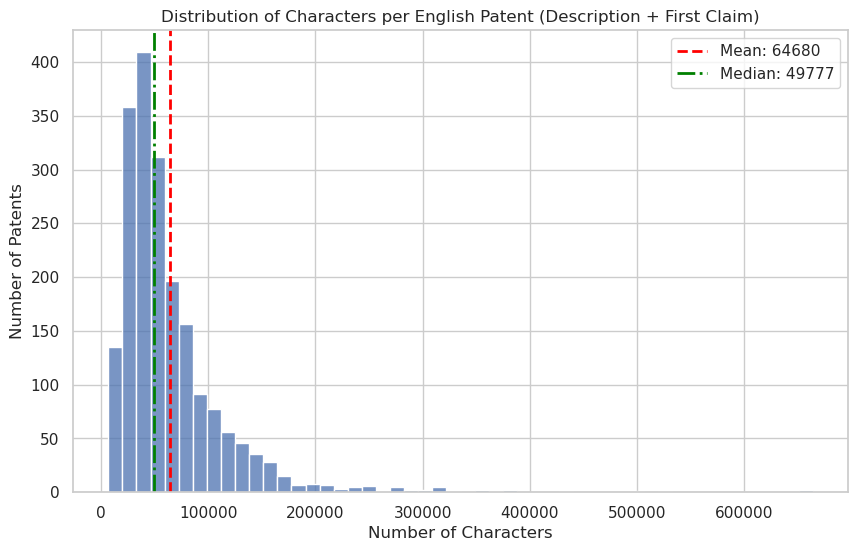

In [8]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

folder = "./xml/20250101"

char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # ----------------------
            # 1. Ensure description is in English
            # ----------------------
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue  # skip this patent entirely

            texts = []

            # Description text
            desc_text = "".join(desc.itertext())
            if desc_text.strip():
                texts.append(desc_text)

            # ----------------------
            # 2. First claim only (num="0001") in English
            # ----------------------
            claim1 = root.find(".//claims[@lang='en']/claim[@num='0001']")
            if claim1 is not None:
                claim1_text = "".join(claim1.itertext())
                if claim1_text.strip():
                    texts.append(claim1_text)

            # Combine & count characters
            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())  # normalize whitespace
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Statistics + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (English only, first claim only)")
    print(f"Average characters (description + claim 1): {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters per English Patent (Description + First Claim)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML files")


# Replacing some tags that aren't suitable for NLP or pretraining with special tokens

Processed 1977 XML patents (English only, first claim only, tokens inserted)
Average characters: 63941
Median characters: 49357
Max characters: 666545


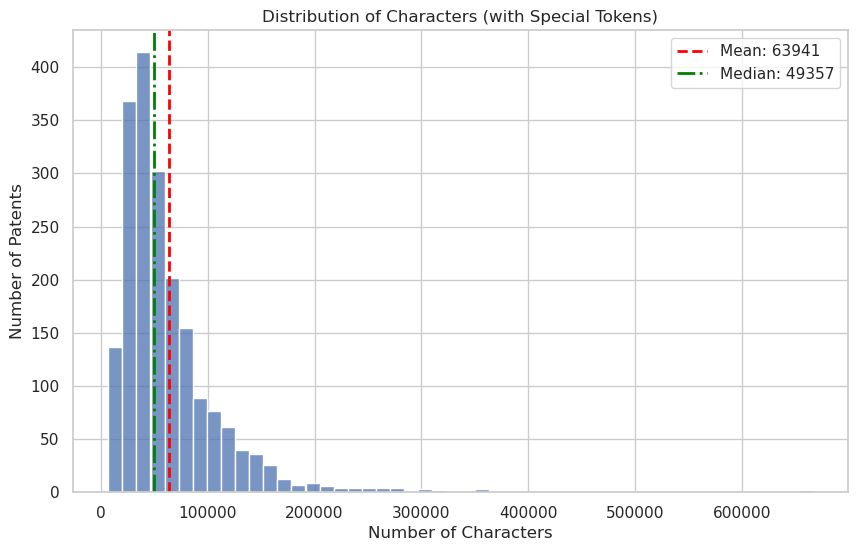

In [9]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

folder = "./xml/20250101"

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>"
}

def extract_with_tokens(elem):
    """
    Traverse XML element, replace tags with tokens if in SPECIAL_TOKENS,
    otherwise recursively extract their text.
    """
    parts = []

    if elem.text:
        parts.append(elem.text)

    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            parts.append(extract_with_tokens(child))

        if child.tail:
            parts.append(child.tail)

    return "".join(parts)


char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # 1. English description
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue

            texts = []

            desc_text = extract_with_tokens(desc)
            if desc_text.strip():
                texts.append(desc_text)

            # 2. First claim only (English)
            claim1 = root.find(".//claims[@lang='en']/claim[@num='0001']")
            if claim1 is not None:
                claim1_text = extract_with_tokens(claim1)
                if claim1_text.strip():
                    texts.append(claim1_text)

            # Combine & normalize
            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())  # normalize whitespace
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Stats + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (English only, first claim only, tokens inserted)")
    print(f"Average characters: {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (with Special Tokens)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML files")


> Small change.  However, this will be more pronounced during actual tokenization.

# Replace nums

Processed 1977 XML patents (EN only, first claim, tokens + number replacement)
Average characters: 65192
Median characters: 50247
Max characters: 669984


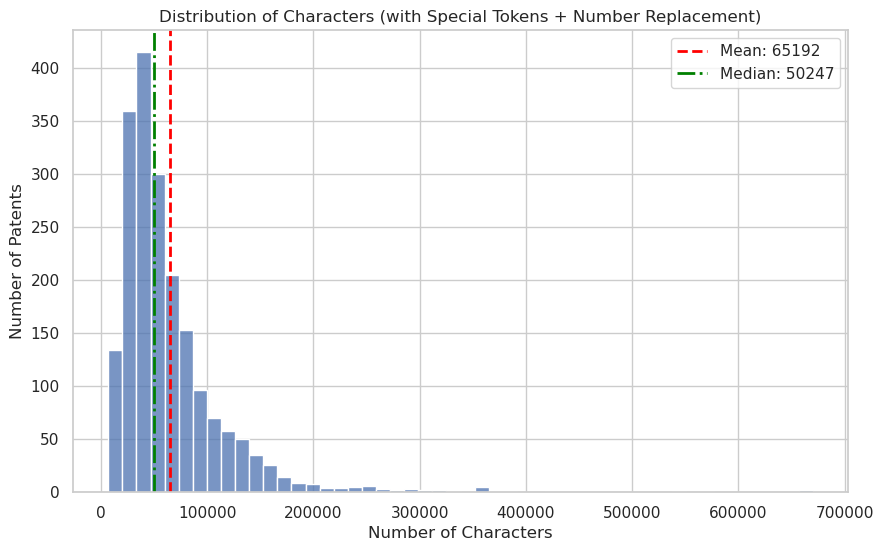

In [12]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

folder = "./xml/20250101"

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>"
}

# Units to normalize numbers
UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "nm"
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

# Regex to match numbers with optional decimal, +/- and optional SI unit
NUM_REGEX = re.compile(rf"\b\d+(\.\d+)?\s*({UNIT_PATTERN})?\b", flags=re.IGNORECASE)

def normalize_numbers(text: str) -> str:
    return NUM_REGEX.sub("<NUM>", text)

def extract_with_tokens(elem):
    """
    Traverse XML element, replacing tags with tokens if in SPECIAL_TOKENS,
    otherwise recursively extract text. Normalizes numbers.
    """
    parts = []

    if elem.text:
        parts.append(normalize_numbers(elem.text))

    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            # Replace whole tag with token
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            # Recurse normally
            parts.append(extract_with_tokens(child))

        if child.tail:
            parts.append(normalize_numbers(child.tail))

    return "".join(parts)


char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # 1. English description required
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue

            texts = []

            desc_text = extract_with_tokens(desc)
            if desc_text.strip():
                texts.append(desc_text)

            # 2. First claim only (English)
            claim1 = root.find(".//claims[@lang='en']/claim[@num='0001']")
            if claim1 is not None:
                claim1_text = extract_with_tokens(claim1)
                if claim1_text.strip():
                    texts.append(claim1_text)

            # Combine & normalize whitespace
            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Stats + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (EN only, first claim, tokens + number replacement)")
    print(f"Average characters: {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (with Special Tokens + Number Replacement)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML")


> Increase expected as 1 has been turned in 5 chars, will affect tokenization though (with custom tokenizer).

**About a 22% drop just via a view bits of simple cleaning**

# Replace headings 
*insert as HEAD tag, so can use for segmentation later*

Processed 1977 XML patents (EN only, first claim, tokens + number replacement)
Average characters: 64831
Median characters: 50120
Max characters: 668133


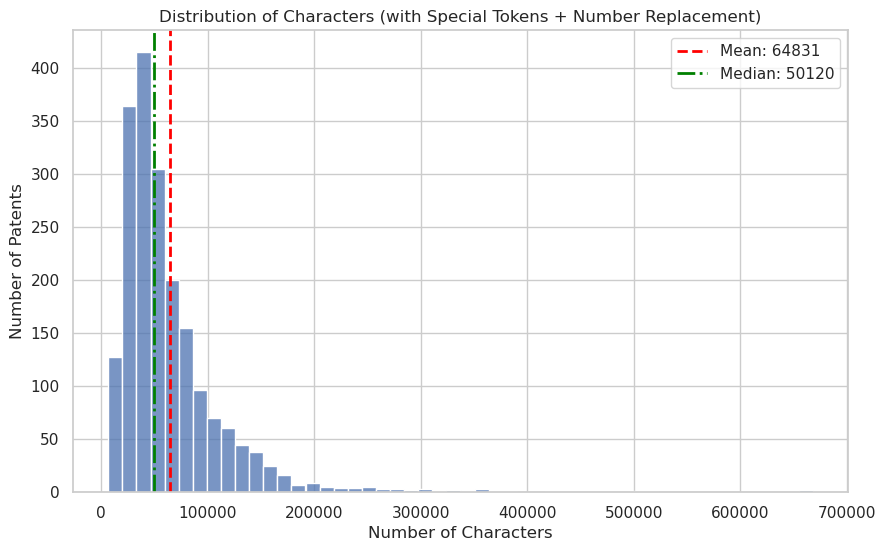

In [2]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

folder = "./xml/20250101"

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>",
    "heading": "<HEAD>"
}

# Units to normalize numbers
UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "nm"
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

# Regex to match numbers with optional decimal, +/- and optional SI unit
NUM_REGEX = re.compile(rf"\b\d+(\.\d+)?\s*({UNIT_PATTERN})?\b", flags=re.IGNORECASE)

def normalize_numbers(text: str) -> str:
    return NUM_REGEX.sub("<NUM>", text)

def extract_with_tokens(elem):
    """
    Traverse XML element, replacing tags with tokens if in SPECIAL_TOKENS,
    otherwise recursively extract text. Normalizes numbers.
    """
    parts = []

    if elem.text:
        parts.append(normalize_numbers(elem.text))

    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            # Replace whole tag with token
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            # Recurse normally
            parts.append(extract_with_tokens(child))

        if child.tail:
            parts.append(normalize_numbers(child.tail))

    return "".join(parts)


char_counts = []
num_files = 0

for file in os.listdir(folder):
    if file.endswith(".xml"):
        filepath = os.path.join(folder, file)
        try:
            tree = etree.parse(filepath)
            root = tree.getroot()

            # 1. English description required
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue

            texts = []

            desc_text = extract_with_tokens(desc)
            if desc_text.strip():
                texts.append(desc_text)

            # 2. First claim only (English)
            claim1 = root.find(".//claims[@lang='en']/claim[@num='0001']")
            if claim1 is not None:
                claim1_text = extract_with_tokens(claim1)
                if claim1_text.strip():
                    texts.append(claim1_text)

            # Combine & normalize whitespace
            if texts:
                combined_text = " ".join(texts)
                combined_text = " ".join(combined_text.split())
                char_counts.append(len(combined_text))
                num_files += 1

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# ------------------------
# Stats + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (EN only, first claim, tokens + number replacement)")
    print(f"Average characters: {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (with Special Tokens + Number Replacement)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML")


# Save as JSONL to inspect

JSONL file written to patents_cleaned.jsonl
Processed 1977 XML patents (EN only, first claim, tokens + number replacement)
Average characters: 64288
Median characters: 49717
Max characters: 663278


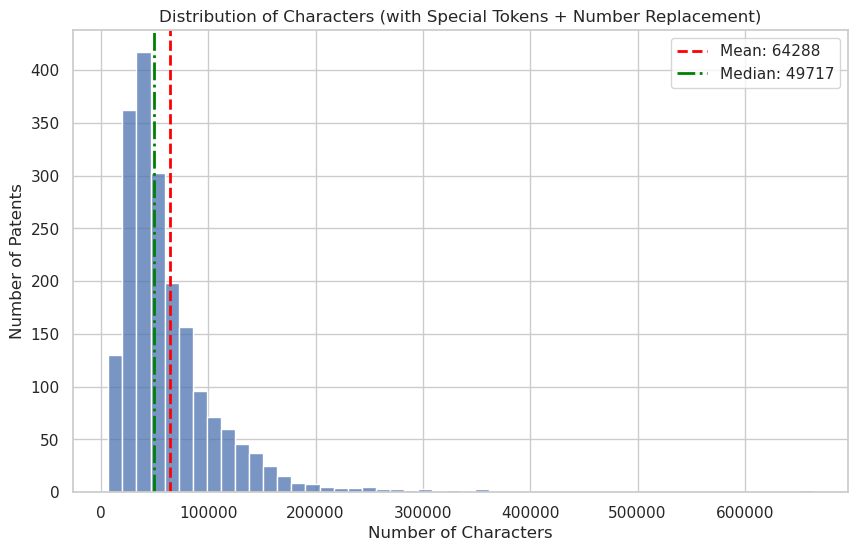

In [11]:
from lxml import etree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import json

folder = "./xml/20250101"
output_file = "patents_cleaned.jsonl"

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>",
    "heading": "<HEAD>"
}

# Units to normalize numbers
UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "nm"
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

# Regex to match numbers with optional decimal, +/- and optional SI unit
NUM_REGEX = re.compile(rf"\b\d+(\.\d+)?\s*({UNIT_PATTERN})?\b", flags=re.IGNORECASE)

def normalize_numbers(text: str) -> str:
    return NUM_REGEX.sub("<NUM>", text)

def extract_with_tokens(elem):
    """
    Traverse XML element, replacing tags with tokens if in SPECIAL_TOKENS,
    otherwise recursively extract text. Normalizes numbers.
    """
    parts = []

    if elem.text:
        parts.append(normalize_numbers(elem.text))

    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            # Replace whole tag with token
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            # Recurse normally
            parts.append(extract_with_tokens(child))

        if child.tail:
            parts.append(normalize_numbers(child.tail))

    return "".join(parts)


char_counts = []
num_files = 0

with open(output_file, "w", encoding="utf-8") as f_out:
    for file in os.listdir(folder):
        if file.endswith(".xml"):
            filepath = os.path.join(folder, file)
            try:
                parser = etree.XMLParser(remove_comments=True)
                tree = etree.parse(filepath, parser)
                root = tree.getroot()

                # 1. English description required
                desc = root.find(".//description[@lang='en']")
                if desc is None:
                    continue

                desc_text = extract_with_tokens(desc).strip()

                # 2. First claim only (English)
                claim1 = root.find(".//claims[@lang='en']/claim[@num='0001']")
                claim1_text = extract_with_tokens(claim1).strip() if claim1 is not None else ""

                if desc_text or claim1_text:
                    # Save JSONL entry
                    record = {
                        "description": desc_text,
                        "claim1": claim1_text
                    }
                    f_out.write(json.dumps(record, ensure_ascii=False) + "\n")

                    # Track char count for stats
                    combined_text = " ".join([desc_text, claim1_text]).strip()
                    char_counts.append(len(combined_text))
                    num_files += 1

            except Exception as e:
                print(f"Error parsing {file}: {e}")

print(f"JSONL file written to {output_file}")

# ------------------------
# Stats + Histogram
# ------------------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_files} XML patents (EN only, first claim, tokens + number replacement)")
    print(f"Average characters: {avg_chars:.0f}")
    print(f"Median characters: {median_chars:.0f}")
    print(f"Max characters: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    # Mean + median lines
    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (with Special Tokens + Number Replacement)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.show()
else:
    print("No valid English text found in any XML")


In [18]:
import random

with open(output_file, 'r') as f:
    patents = f.readlines()

random.choice(patents)[:500]

'{"description": "The present invention relates to a method for estimating lifetime consumption, in particular a method for estimating lifetime consumption for semiconductor devices for vehicle applications.\\n\\nWith increased interest being placed in environmentally friendly vehicles there has been a corresponding increase in interest in the use of electric motors for providing drive torque for electric vehicles.\\n\\nElectric motors work on the principle that a current carrying wire will experienc'

# Better paragraph handling

Saved 1977 documents to cleaned_patents.jsonl
Processed 1977 documents (EN only, first claim).
Average chars: 64428, Median: 49832, Max: 664329


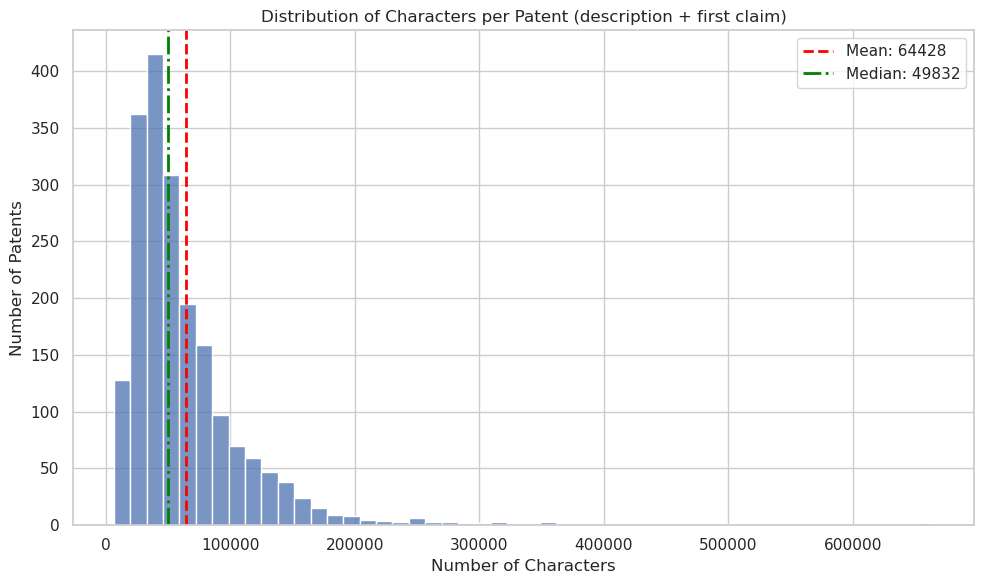

In [25]:
from lxml import etree
import os
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- user params ----------
folder = "./xml/20250101"
output_file = "cleaned_patents.jsonl"
# ---------------------------------

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>",
    "heading": "<HEAD>",
}

UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "us", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "um", "nm",
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

# pick patterns that avoid matching inside words like CO2 (requires non-letter before)
NUM_REGEX = re.compile(
    rf"(?<![A-Za-z])\b\d+(\.\d+)?\s*(?:{UNIT_PATTERN})?\b(?![A-Za-z])",
    flags=re.IGNORECASE,
)

def normalize_numbers(text: str) -> str:
    if not text:
        return text
    return NUM_REGEX.sub("<NUM>", text)

def normalize_whitespace_preserve_paragraphs(text: str) -> str:
    # unify newlines
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    # remove spaces before and after newlines
    text = re.sub(r"[ \t]+\n", "\n", text)
    text = re.sub(r"\n[ \t]+", "\n", text)
    # collapse spaces/tabs
    text = re.sub(r"[ \t]+", " ", text)
    # collapse 3+ newlines to 2 (preserve paragraph separation)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_with_tokens(elem, preserve_paragraphs=False):
    """
    Recursively extract text from elem.
    - replace any child tag in SPECIAL_TOKENS with its token (skip child contents)
    - apply number normalization to text/tails
    - if preserve_paragraphs=True, treat direct <p> children as paragraphs
    """
    # If the element itself is a special token, return token (drop contents)
    if elem.tag in SPECIAL_TOKENS:
        return SPECIAL_TOKENS[elem.tag]

    # If we are asked to preserve paragraphs and this is a <p>, build paragraph text only for this element
    if preserve_paragraphs and elem.tag == "p":
        parts = []
        if elem.text:
            parts.append(normalize_numbers(elem.text))
        for child in elem:
            if child.tag in SPECIAL_TOKENS:
                parts.append(SPECIAL_TOKENS[child.tag])
            else:
                parts.append(extract_with_tokens(child, preserve_paragraphs))
            if child.tail:
                parts.append(normalize_numbers(child.tail))
        return "".join(parts).strip()

    # Default recursive assembly
    parts = []
    if elem.text:
        parts.append(normalize_numbers(elem.text))
    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            parts.append(extract_with_tokens(child, preserve_paragraphs))
        if child.tail:
            parts.append(normalize_numbers(child.tail))
    return "".join(parts)

# ----------------- main processing -----------------
char_counts = []
num_docs = 0

# create parser that removes comments
parser = etree.XMLParser(remove_comments=True, recover=True)

with open(output_file, "w", encoding="utf-8") as fout:
    for fname in os.listdir(folder):
        if not fname.endswith(".xml"):
            continue
        path = os.path.join(folder, fname)
        try:
            tree = etree.parse(path, parser)
            root = tree.getroot()

            # require English description
            desc = root.find(".//description[@lang='en']")
            if desc is None:
                continue

            # collect paragraphs (preserve p tags as paragraphs)
            paras = []
            for p in desc.findall(".//p"):
                p_text = extract_with_tokens(p, preserve_paragraphs=True)
                if p_text:
                    # normalize numbers already done; clean spaces inside paragraph
                    p_text = re.sub(r"[ \t]+", " ", p_text).strip()
                    paras.append(p_text)

            if paras:
                desc_text = "\n\n".join(paras)
            else:
                # fallback: extract whole desc as single block
                desc_text = extract_with_tokens(desc, preserve_paragraphs=False)

            desc_text = normalize_whitespace_preserve_paragraphs(desc_text)

            # first English claim only
            claim1_elem = root.find(".//claims[@lang='en']/claim[@num='0001']")
            claim1_text = ""
            if claim1_elem is not None:
                claim1_text = extract_with_tokens(claim1_elem, preserve_paragraphs=False)
                claim1_text = normalize_whitespace_preserve_paragraphs(claim1_text)

            if desc_text.strip() or claim1_text.strip():
                record = {
                    "filename": fname,
                    "description": desc_text,
                    "claim1": claim1_text,
                }
                fout.write(json.dumps(record, ensure_ascii=False) + "\n")
                num_docs += 1

                combined = (desc_text + " " + claim1_text).strip()
                # collapse extra spaces for char counting
                combined = " ".join(combined.split())
                char_counts.append(len(combined))

        except Exception as e:
            print(f"Error parsing {fname}: {e}")

print(f"Saved {num_docs} documents to {output_file}")

# ----------------- stats + plot -----------------
if char_counts:
    avg_chars = np.mean(char_counts)
    median_chars = np.median(char_counts)
    max_chars = max(char_counts)

    print(f"Processed {num_docs} documents (EN only, first claim).")
    print(f"Average chars: {avg_chars:.0f}, Median: {median_chars:.0f}, Max: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(char_counts, bins=50, kde=False)

    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters per Patent (description + first claim)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid English patents found")


In [34]:
import random

with open(output_file, 'r') as f:
    patents = f.readlines()

json.loads(random.choice(patents))

{'filename': '152.xml',
 'description': 'This specification relates to modifying neural network structures to generate better-performing neural networks.\n\nNeural networks are machine learning models that employ one or more layers of nonlinear units to predict an output for a received input. Some neural networks include one or more hidden layers in addition to an output layer. The output of each hidden layer is used as input to the next layer in the network, i.e., the next hidden layer or the output layer. Each layer of the network generates an output from a received input in accordance with current values of a respective set of parameters.\n\n<NPL>), discloses that, while depth tends to improve network performances, it also makes gradient-based training more difficult since deeper networks tend to be more non-linear. Training of a student network that is deeper and thinner than the teacher network, using not only the outputs but also the intermediate representations learned by the te

# Removing the tail

In [28]:
import numpy as np

# compute cutoff (95th percentile)
cutoff = np.percentile(char_counts, 95)
print(f"95th percentile cutoff: {cutoff:.0f} characters")

# filter counts
filtered_counts = [c for c in char_counts if c <= cutoff]

print(f"Before filtering: {len(char_counts)} docs")
print(f"After filtering:  {len(filtered_counts)} docs")

avg_chars = np.mean(filtered_counts)
median_chars = np.median(filtered_counts)

print(f"Filtered avg chars: {avg_chars:.0f}, median: {median_chars:.0f}")


95th percentile cutoff: 151426 characters
Before filtering: 1977 docs
After filtering:  1878 docs
Filtered avg chars: 55716, median: 47720


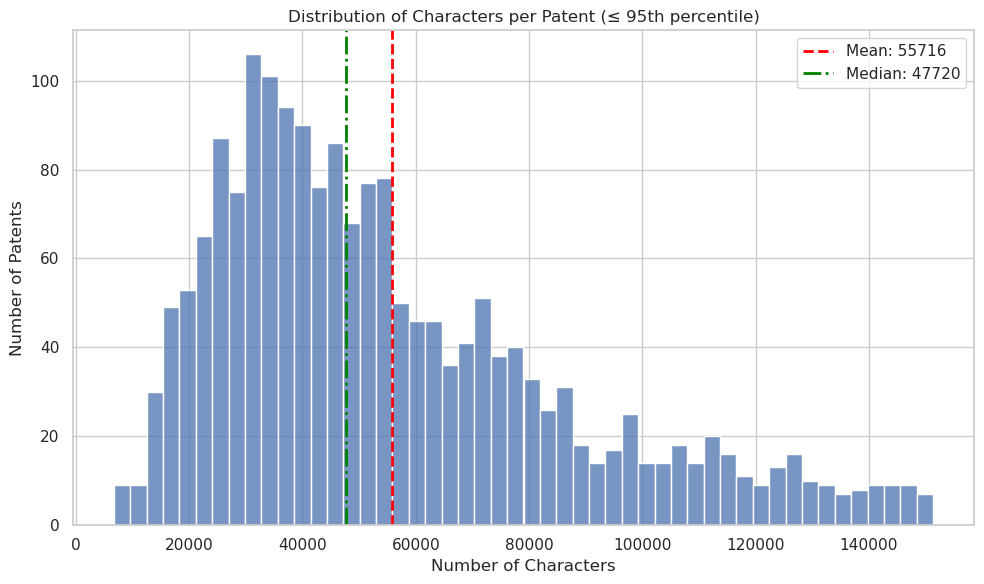

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(filtered_counts, bins=50, kde=False)

plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

plt.title("Distribution of Characters per Patent (≤ 95th percentile)")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Patents")
plt.legend()
plt.tight_layout()
plt.show()

# Drop first and last paragraphs

Parsed 1977 documents before cutoff
95th percentile cutoff: 150634 characters
After cutoff: 1878 documents
Filtered avg: 54950, median: 46898, max: 150611


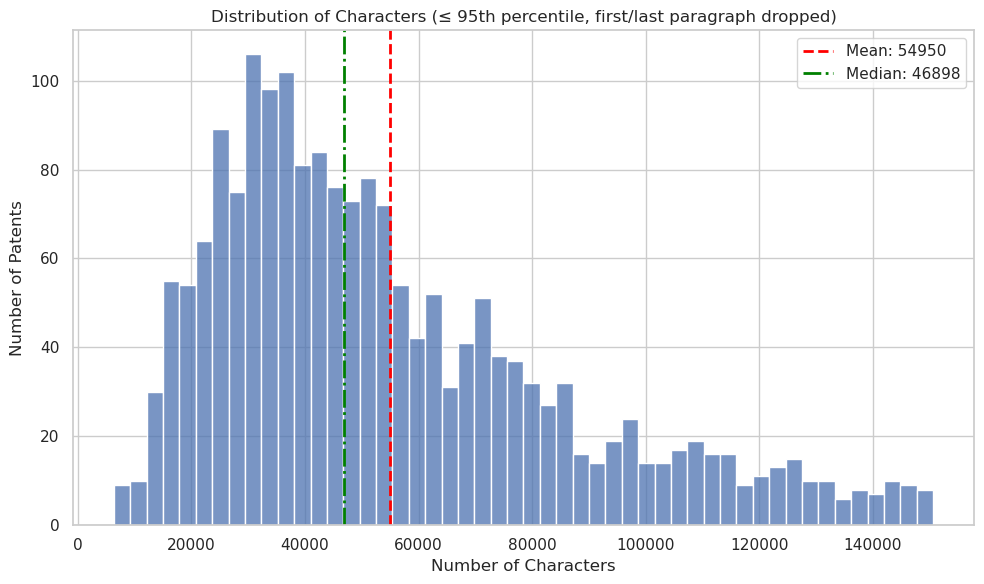

In [35]:
from lxml import etree
import os
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- user params ----------
folder = "./xml/20250101"
output_file = "cleaned_patents.jsonl"
# ---------------------------------

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>",
    "heading": "<HEAD>",
}

UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "us", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "um", "nm",
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

NUM_REGEX = re.compile(
    rf"(?<![A-Za-z])\b\d+(\.\d+)?\s*(?:{UNIT_PATTERN})?\b(?![A-Za-z])",
    flags=re.IGNORECASE,
)

def normalize_numbers(text: str) -> str:
    if not text:
        return text
    return NUM_REGEX.sub("<NUM>", text)

def normalize_whitespace_preserve_paragraphs(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+\n", "\n", text)
    text = re.sub(r"\n[ \t]+", "\n", text)
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_with_tokens(elem, preserve_paragraphs=False):
    if elem.tag in SPECIAL_TOKENS:
        return SPECIAL_TOKENS[elem.tag]

    if preserve_paragraphs and elem.tag == "p":
        parts = []
        if elem.text:
            parts.append(normalize_numbers(elem.text))
        for child in elem:
            if child.tag in SPECIAL_TOKENS:
                parts.append(SPECIAL_TOKENS[child.tag])
            else:
                parts.append(extract_with_tokens(child, preserve_paragraphs))
            if child.tail:
                parts.append(normalize_numbers(child.tail))
        return "".join(parts).strip()

    parts = []
    if elem.text:
        parts.append(normalize_numbers(elem.text))
    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            parts.append(extract_with_tokens(child, preserve_paragraphs))
        if child.tail:
            parts.append(normalize_numbers(child.tail))
    return "".join(parts)

def drop_first_last_paragraphs(text: str) -> str:
    paragraphs = text.split("\n\n")
    if len(paragraphs) > 2:
        paragraphs = paragraphs[1:-1]
    return "\n\n".join(paragraphs).strip()

# ----------------- main processing -----------------
records = []
char_counts = []

parser = etree.XMLParser(remove_comments=True, recover=True)

for fname in os.listdir(folder):
    if not fname.endswith(".xml"):
        continue
    path = os.path.join(folder, fname)
    try:
        tree = etree.parse(path, parser)
        root = tree.getroot()

        desc = root.find(".//description[@lang='en']")
        if desc is None:
            continue

        paras = []
        for p in desc.findall(".//p"):
            p_text = extract_with_tokens(p, preserve_paragraphs=True)
            if p_text:
                p_text = re.sub(r"[ \t]+", " ", p_text).strip()
                paras.append(p_text)

        if paras:
            desc_text = "\n\n".join(paras)
        else:
            desc_text = extract_with_tokens(desc, preserve_paragraphs=False)

        desc_text = normalize_whitespace_preserve_paragraphs(desc_text)
        desc_text = drop_first_last_paragraphs(desc_text)

        claim1_elem = root.find(".//claims[@lang='en']/claim[@num='0001']")
        claim1_text = ""
        if claim1_elem is not None:
            claim1_text = extract_with_tokens(claim1_elem, preserve_paragraphs=False)
            claim1_text = normalize_whitespace_preserve_paragraphs(claim1_text)

        if desc_text.strip() or claim1_text.strip():
            combined = (desc_text + " " + claim1_text).strip()
            combined = " ".join(combined.split())
            records.append({
                "filename": fname,
                "description": desc_text,
                "claim1": claim1_text,
                "length": len(combined),
            })
            char_counts.append(len(combined))

    except Exception as e:
        print(f"Error parsing {fname}: {e}")

print(f"Parsed {len(records)} documents before cutoff")

# ----------------- apply 95th percentile cutoff -----------------
cutoff = np.percentile(char_counts, 95) if char_counts else 0
print(f"95th percentile cutoff: {cutoff:.0f} characters")

filtered = [r for r in records if r["length"] <= cutoff]
print(f"After cutoff: {len(filtered)} documents")

# save JSONL
with open(output_file, "w", encoding="utf-8") as fout:
    for rec in filtered:
        rec_out = {k: rec[k] for k in ["filename", "description", "claim1"]}
        fout.write(json.dumps(rec_out, ensure_ascii=False) + "\n")

# ----------------- stats + plot -----------------
if filtered:
    lens = [r["length"] for r in filtered]
    avg_chars = np.mean(lens)
    median_chars = np.median(lens)
    max_chars = max(lens)

    print(f"Filtered avg: {avg_chars:.0f}, median: {median_chars:.0f}, max: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(lens, bins=50, kde=False)

    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (≤ 95th percentile, first/last paragraph dropped)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid patents after filtering")


# Drop ul, ol and dl

Parsed 1977 documents before cutoff
95th percentile cutoff: 145512 characters
After cutoff: 1878 documents
Filtered avg: 51853, median: 44213, max: 145352


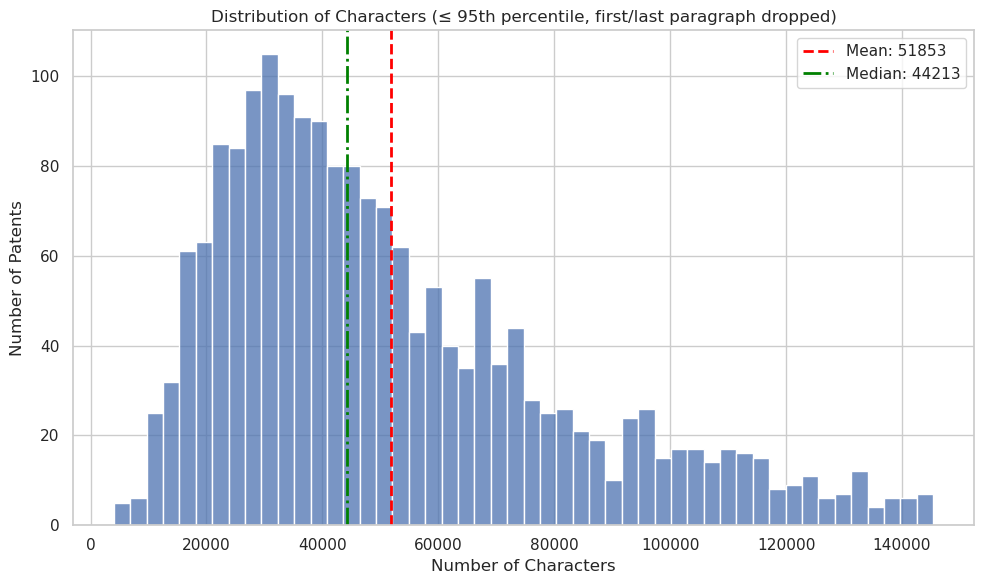

In [37]:
from lxml import etree
import os
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- user params ----------
folder = "./xml/20250101"
output_file = "coarse_cleaned_patents.jsonl"
# ---------------------------------

SPECIAL_TOKENS = {
    "table": "<TAB>",
    "img": "<IMG>",
    "figref": "<FIG>",
    "patcit": "<CIT>",
    "nplcit": "<NPL>",
    "chemistry": "<CHM>",
    "maths": "<MAT>",
    "heading": "<HEAD>",
    "ol": "",
    "ul": "",
    "dl": ""
}

UNITS = [
    "mm", "cm", "m", "km",
    "mg", "g", "kg",
    "ml", "l",
    "s", "ms", "µs", "us", "min", "h",
    "hz", "khz", "mhz", "ghz",
    "°c", "k",
    "µm", "um", "nm",
]
UNIT_PATTERN = "|".join(map(re.escape, UNITS))

NUM_REGEX = re.compile(
    rf"(?<![A-Za-z])\b\d+(\.\d+)?\s*(?:{UNIT_PATTERN})?\b(?![A-Za-z])",
    flags=re.IGNORECASE,
)

def normalize_numbers(text: str) -> str:
    if not text:
        return text
    return NUM_REGEX.sub("<NUM>", text)

def normalize_whitespace_preserve_paragraphs(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+\n", "\n", text)
    text = re.sub(r"\n[ \t]+", "\n", text)
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_with_tokens(elem, preserve_paragraphs=False):
    if elem.tag in SPECIAL_TOKENS:
        return SPECIAL_TOKENS[elem.tag]

    if preserve_paragraphs and elem.tag == "p":
        parts = []
        if elem.text:
            parts.append(normalize_numbers(elem.text))
        for child in elem:
            if child.tag in SPECIAL_TOKENS:
                parts.append(SPECIAL_TOKENS[child.tag])
            else:
                parts.append(extract_with_tokens(child, preserve_paragraphs))
            if child.tail:
                parts.append(normalize_numbers(child.tail))
        return "".join(parts).strip()

    parts = []
    if elem.text:
        parts.append(normalize_numbers(elem.text))
    for child in elem:
        if child.tag in SPECIAL_TOKENS:
            parts.append(SPECIAL_TOKENS[child.tag])
        else:
            parts.append(extract_with_tokens(child, preserve_paragraphs))
        if child.tail:
            parts.append(normalize_numbers(child.tail))
    return "".join(parts)

def drop_first_last_paragraphs(text: str) -> str:
    paragraphs = text.split("\n\n")
    if len(paragraphs) > 2:
        paragraphs = paragraphs[1:-1]
    return "\n\n".join(paragraphs).strip()

# ----------------- main processing -----------------
records = []
char_counts = []

parser = etree.XMLParser(remove_comments=True, recover=True)

for fname in os.listdir(folder):
    if not fname.endswith(".xml"):
        continue
    path = os.path.join(folder, fname)
    try:
        tree = etree.parse(path, parser)
        root = tree.getroot()

        desc = root.find(".//description[@lang='en']")
        if desc is None:
            continue

        paras = []
        for p in desc.findall(".//p"):
            p_text = extract_with_tokens(p, preserve_paragraphs=True)
            if p_text:
                p_text = re.sub(r"[ \t]+", " ", p_text).strip()
                paras.append(p_text)

        if paras:
            desc_text = "\n\n".join(paras)
        else:
            desc_text = extract_with_tokens(desc, preserve_paragraphs=False)

        desc_text = normalize_whitespace_preserve_paragraphs(desc_text)
        desc_text = drop_first_last_paragraphs(desc_text)

        claim1_elem = root.find(".//claims[@lang='en']/claim[@num='0001']")
        claim1_text = ""
        if claim1_elem is not None:
            claim1_text = extract_with_tokens(claim1_elem, preserve_paragraphs=False)
            claim1_text = normalize_whitespace_preserve_paragraphs(claim1_text)

        if desc_text.strip() or claim1_text.strip():
            combined = (desc_text + " " + claim1_text).strip()
            combined = " ".join(combined.split())
            records.append({
                "filename": fname,
                "description": desc_text,
                "claim1": claim1_text,
                "length": len(combined),
            })
            char_counts.append(len(combined))

    except Exception as e:
        print(f"Error parsing {fname}: {e}")

print(f"Parsed {len(records)} documents before cutoff")

# ----------------- apply 95th percentile cutoff -----------------
cutoff = np.percentile(char_counts, 95) if char_counts else 0
print(f"95th percentile cutoff: {cutoff:.0f} characters")

filtered = [r for r in records if r["length"] <= cutoff]
print(f"After cutoff: {len(filtered)} documents")

# save JSONL
with open(output_file, "w", encoding="utf-8") as fout:
    for rec in filtered:
        rec_out = {k: rec[k] for k in ["filename", "description", "claim1"]}
        fout.write(json.dumps(rec_out, ensure_ascii=False) + "\n")

# ----------------- stats + plot -----------------
if filtered:
    lens = [r["length"] for r in filtered]
    avg_chars = np.mean(lens)
    median_chars = np.median(lens)
    max_chars = max(lens)

    print(f"Filtered avg: {avg_chars:.0f}, median: {median_chars:.0f}, max: {max_chars}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.histplot(lens, bins=50, kde=False)

    plt.axvline(avg_chars, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_chars:.0f}")
    plt.axvline(median_chars, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_chars:.0f}")

    plt.title("Distribution of Characters (≤ 95th percentile, first/last paragraph dropped)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Patents")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid patents after filtering")


**~31% reduction**

# Final Pipeline (folders and pub folders)

In [2]:
# run coarse_clean_patents.py

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import load_dataset

# Load the JSONL file
dataset = load_dataset("json", data_files="coarse_cleaned_patents.jsonl")

dataset = dataset["train"]

# Push to Hugging Face Hub
dataset.push_to_hub("mhurhangee/ep-patents-coarse-cleaned")

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/12 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  525kB /  170MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  166MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  171MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  171MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  171MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  171MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  167MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         | 7.35MB /  166MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  169MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  169MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  171MB            

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         | 3.67MB /  169MB            

CommitInfo(commit_url='https://huggingface.co/datasets/mhurhangee/ep-patents-coarse-cleaned/commit/83e02cf4635043fc5761b0eead36f4cd69ed370b', commit_message='Upload dataset', commit_description='', oid='83e02cf4635043fc5761b0eead36f4cd69ed370b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mhurhangee/ep-patents-coarse-cleaned', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mhurhangee/ep-patents-coarse-cleaned'), pr_revision=None, pr_num=None)